# Part 2 - Classification using fast.ai
In my last yeay's [eargasm music project](https://github.com/adamsiemaszkiewicz/eargasm-music), I classified my music library using pre-developed audio features extracted using Spotify API. This project is an attempt to test new ways of classifying sounds based on their raw sound representation and, later on, try to ensamble various different methods for a better performing classifier.

This notebook will use the audio clips converted into spectogram images in the previous step to build a classification model using fast.ai.

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/sound_classifier /mydrive

# navigate to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/sound_classifier


## Import libraries
- `numpy` - linear algebra
- `pandas` -  data manipulation & analysis
- `os` - operating system interfaces
- `tqdm` - progress bars
- `matplotlib` - visualization plotting
- `librosa` - audio & music processing
- `IPython.display` - audio previews

In [3]:
# import numpy as np
# import pandas as pd
# import os
# from os.path import basename
# import matplotlib.pyplot as plt
# import soundfile as sf
# import librosa
# import librosa.display
# import IPython.display as display
# import tqdm.notebook as tq

## fast.ai
Install & import latest version of fast.ai high-level deep learning library and load its computer vision modules.

In [4]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 15.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 12.8MB 222kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [5]:
import fastai
print(f'fast.ai version: {fastai.__version__}')
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

fast.ai version: 2.3.0


# Proprocessing
Environment Sound Classification

## Load meta data

In [6]:
# path to csv file containing meta data for the dataset
META_CSV = './ESC-50/meta/esc50.csv'

# path to folder containing audio files
AUDIO_PATH = './ESC-50/audio/'

In [7]:
df = pd.read_csv(META_CSV)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Reproducability
Set the global seed to ensure reproducability throughout the code.

In [8]:
set_seed(0)

## Dataset
Let's set the path where our dataset is located and see how our data is stored.

### Path
Set the main dataset path.

In [9]:
path = Path('./spectograms/')
path.ls()

(#2001) [Path('spectograms/3-151212-A-24.png'),Path('spectograms/3-151213-A-24.png'),Path('spectograms/3-151255-A-28.png'),Path('spectograms/3-151269-A-35.png'),Path('spectograms/3-151273-A-35.png'),Path('spectograms/3-151557-A-28.png'),Path('spectograms/3-151557-B-28.png'),Path('spectograms/3-152007-A-20.png'),Path('spectograms/3-152007-B-20.png'),Path('spectograms/3-152007-C-20.png')...]

### Remove duplicate files
Due to some Google Drive related bugs there might be some duplicate files. Let's clean them up.

In [10]:
# iterate through the files in the dataset path
for fname in os.listdir(path):

  # drop the file extension
  name = fname.split('.')[0]
  # check if the filename ends with (1) and remove the file
  if name.endswith('(1)'):
    print(os.path.join(path, fname))
    os.remove(os.path.join(path, fname))

### Image files
Get image files ifrom our path.

In [11]:
fnames = get_image_files(path)
fnames

(#2000) [Path('spectograms/3-151212-A-24.png'),Path('spectograms/3-151213-A-24.png'),Path('spectograms/3-151255-A-28.png'),Path('spectograms/3-151269-A-35.png'),Path('spectograms/3-151273-A-35.png'),Path('spectograms/3-151557-A-28.png'),Path('spectograms/3-151557-B-28.png'),Path('spectograms/3-152007-A-20.png'),Path('spectograms/3-152007-B-20.png'),Path('spectograms/3-152007-C-20.png')...]

### Labels
The naming convention of the dataset is `{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav`. Let's create a regex pattern to extract `{TARGET}` from the filenames. Then, accordingly, change the numerical label to the corresponding category name.

In [12]:
# pat = r'.-(\d+).png'
def label_func(filename):
  # create a regex pattern to extract target number
  pat = r'.-(\d+).png'
  target = int(re.search(pat, filename).group(1))

  # convert target number to category name
  category = df.groupby('target')['category'].unique()[target][0]

  return category

### Item transforms

In [13]:
item_tfms = Resize(256)

## Data loaders
Let's build a `DataLoaders` object which will store the dataset files with their corresponding labels and apply basic 

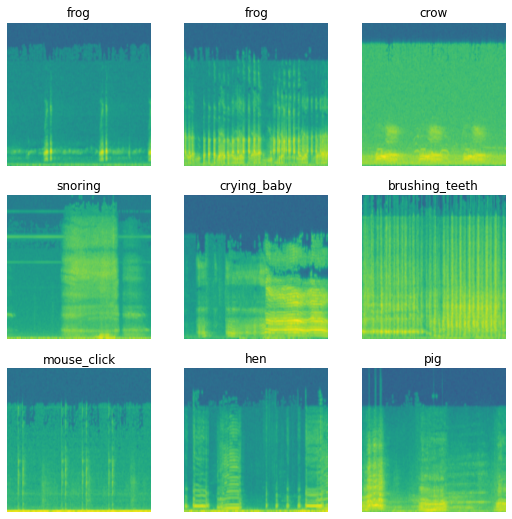

In [14]:
# dls = ImageDataLoaders.from_name_re(
#     path,
#     fnames,
#     pat,
#     item_tfms=Resize(256, method=ResizeMethod.Squish)
#     )

dls = ImageDataLoaders.from_name_func(
    path=path,
    fnames=fnames,
    label_func=label_func,
    item_tfms=item_tfms
    )

dls.show_batch()

# Classifier

## Create a learner

In [15]:
learn = cnn_learner(dls,
                    resnet34,
                    metrics=error_rate,
                    pretrained=True,
                    model_dir='models').to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


## Train for one cycle

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,4.987805,3.962449,0.905000,04:26


## Find optimal learning rate

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

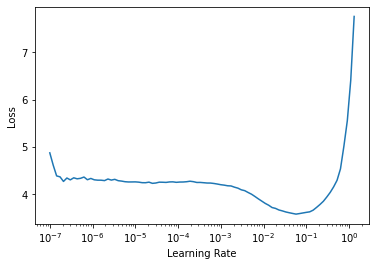

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,3.582321,2.533696,0.605000,00:19


epoch,train_loss,valid_loss,error_rate,time
0,2.101957,1.989233,0.507500,00:19
1,1.647140,1.897915,0.457500,00:19
2,1.548454,2.793210,0.555000,00:19
3,1.398009,1.903860,0.367500,00:19
4,1.167812,1.619970,0.357500,00:20
5,0.914364,1.452923,0.280000,00:19
6,0.699509,1.263573,0.262500,00:19
7,0.503561,1.149838,0.235000,00:20
8,0.369418,1.136108,0.237500,00:19
9,0.285913,1.143514,0.237500,00:19


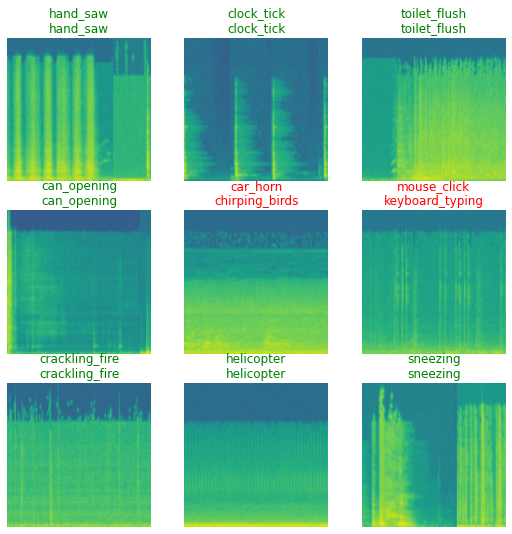

In [20]:
learn.show_results()

In [23]:
# test_dl = learn.dls.test_dl(fnames[:10])
# preds = learn.get_preds(dl=test_dl)

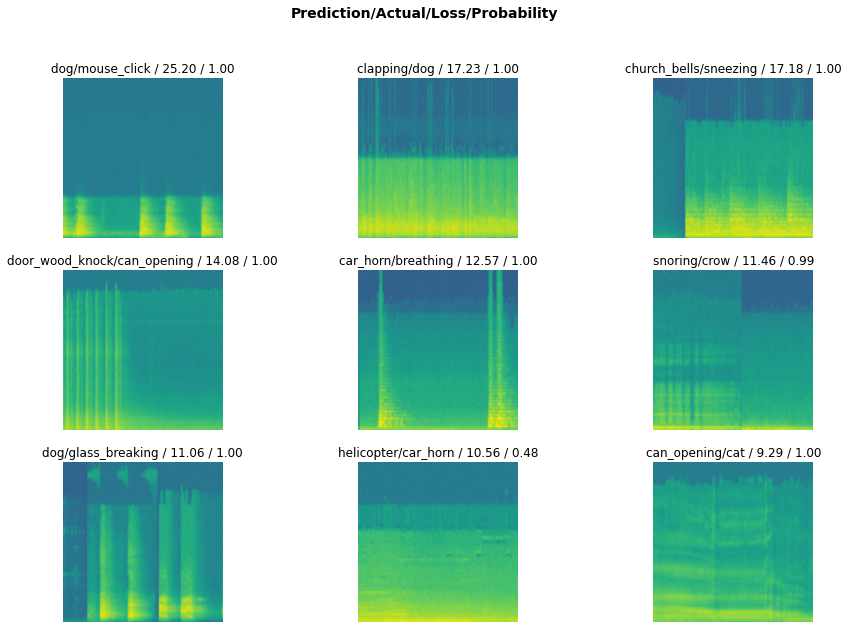

In [24]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

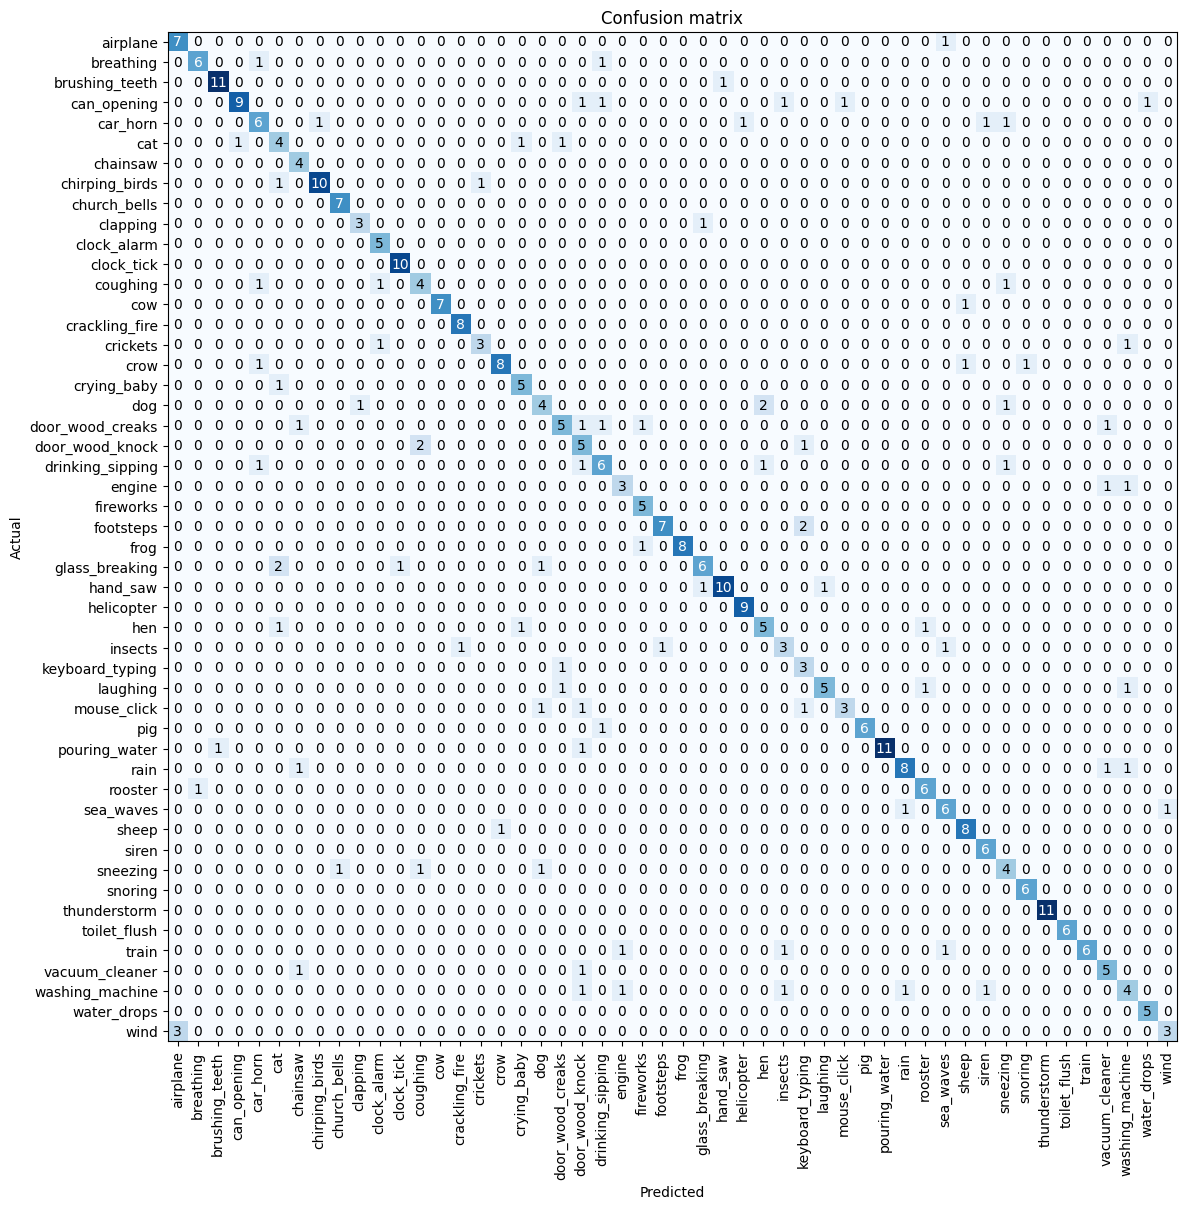

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=100)

In [27]:
interp.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.70      0.88      0.78         8
       breathing       0.86      0.75      0.80         8
  brushing_teeth       0.92      0.92      0.92        12
     can_opening       0.90      0.64      0.75        14
        car_horn       0.60      0.60      0.60        10
             cat       0.44      0.57      0.50         7
        chainsaw       0.57      1.00      0.73         4
  chirping_birds       0.91      0.83      0.87        12
    church_bells       0.88      1.00      0.93         7
        clapping       0.75      0.75      0.75         4
     clock_alarm       0.71      1.00      0.83         5
      clock_tick       0.91      1.00      0.95        10
        coughing       0.57      0.57      0.57         7
             cow       1.00      0.88      0.93         8
  crackling_fire       0.89      1.00      0.94         8
        crickets       0.75      0.60      0.67         5
            c

In [28]:
interp.most_confused()

[('wind', 'airplane', 3),
 ('dog', 'hen', 2),
 ('door_wood_knock', 'coughing', 2),
 ('footsteps', 'keyboard_typing', 2),
 ('glass_breaking', 'cat', 2),
 ('airplane', 'sea_waves', 1),
 ('breathing', 'car_horn', 1),
 ('breathing', 'drinking_sipping', 1),
 ('brushing_teeth', 'hand_saw', 1),
 ('can_opening', 'door_wood_knock', 1),
 ('can_opening', 'drinking_sipping', 1),
 ('can_opening', 'insects', 1),
 ('can_opening', 'mouse_click', 1),
 ('can_opening', 'water_drops', 1),
 ('car_horn', 'chirping_birds', 1),
 ('car_horn', 'helicopter', 1),
 ('car_horn', 'siren', 1),
 ('car_horn', 'sneezing', 1),
 ('cat', 'can_opening', 1),
 ('cat', 'crying_baby', 1),
 ('cat', 'door_wood_creaks', 1),
 ('chirping_birds', 'cat', 1),
 ('chirping_birds', 'crickets', 1),
 ('clapping', 'glass_breaking', 1),
 ('coughing', 'car_horn', 1),
 ('coughing', 'clock_alarm', 1),
 ('coughing', 'sneezing', 1),
 ('cow', 'sheep', 1),
 ('crickets', 'clock_alarm', 1),
 ('crickets', 'washing_machine', 1),
 ('crow', 'car_horn', 1)

In [ ]:
# for filename in tq.tqdm(df['filename']):
#   fold = int(filename[0])
#   if fold in [1, 2, 3]:
#     copy to train
#   elif fold == 4:
#     copy to valid
#   elif fold == 5:
#     copy to test